# Combining deconvolved IRDIS and ZIMPOL images

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import fnmatch
import os
from astropy.io import fits
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
from scipy import interpolate
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from textwrap import wrap
import scipy.ndimage as ndimage
from matplotlib.gridspec import GridSpec
from matplotlib import colors
import functions as f
import pandas as pd
from scipy.optimize import curve_fit
# from scipy import asarray as ar,exp
import numpy.ma as ma




In [2]:
def createfolder(dirName):
    try:
    # Create target Directory
       os.mkdir(dirName)
    except FileExistsError:
        print()#("Directory " , dirName ,  " already exists")   
        
        
def maskcrit(aolp,R):
    phi = (aolp-90)  
    n=aolp.shape[0]
    critarray=np.zeros_like(phi)
    for ix in range (0,n):
        for iy in range(0,n):
            if phi[ix,iy]>180:
                phi[ix,iy]=phi[ix,iy]-180
            
    for ix in range (2,n-2):
        for iy in range(2,n-2):
            if R[ix,iy]>=1:            
                datapix=[]
                for (iix,iiy) in [(ix,iy),(ix-1,iy),(ix+1,iy),(ix,iy-1),(ix,iy+1)]: 
                    if R[iix,iiy]>=1:
                        datapix.append(abs(phi[iix,iiy]))
                            
                
                crit=np.std(datapix)               
                critarray[ix,iy]=crit
                
    for ix in range (0,n-1):
        for iy in range(0,n-1):
            if critarray[ix,iy]==0:
                critarray[ix,iy]=np.max(critarray)
    medianstd=np.nanmedian(critarray)
    
    mask=(critarray<=medianstd)#*R([ix,iy]>=1)
    return mask
        
def plot_AoLP(ps,R,Q,U,I,Q_PHI,PI,AOLP,title,save):
    # First, we plot the background image
    fig = plt.figure(figsize=(8,8))
    i_plot = fig.add_subplot(111)
    n = I.shape[0]
    d = n * ps / 2

    im1=i_plot.imshow(np.arcsinh(Q_PHI), origin='lower',extent=(-d, d, d, -d))

    fig.colorbar(im1, orientation='vertical')

    plt.xlabel('mas')
    plt.ylabel("mas")
    plt.tight_layout(pad=0.1)     

    # ranges of the axis
    xx0, xx1 = i_plot.get_xlim()
    yy0, yy1 = i_plot.get_ylim()

    # binning factor
    factor = [4, 4]

    # re-binned number of points in each axis
    nx_new = PI.shape[1] // factor[0]
    ny_new = PI.shape[0] // factor[1]

    # These are the positions of the quivers
    X,Y = np.meshgrid(np.linspace(xx0,xx1,nx_new,endpoint=True),
                      np.linspace(yy0,yy1,ny_new,endpoint=True))
    # bin the data
    I_bin = I.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    Q_bin = Q.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    U_bin = U.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    Q_phi_bin = Q_PHI.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    PI_bin=PI.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    R_bin=R.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    aolp_bin=AOLP.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)

    # polarization angle
    psi=0.5*np.arctan2(U_bin, Q_bin)

    #psi=aolp_bin
    #i_plot.imshow(psi, origin='lower',extent=(-d, d, d, -d))

    # polarization fraction
    frac =Q_phi_bin/I_bin
    #frac=dolp_v[adc:bdc,adc:bdc]
    # mask to show only alighned

    mask1=maskcrit(psi,R_bin)
    mask2=Q_phi_bin>=10
    mask=mask2#*mask1
    #print('max DoLP in region %.3f percent'%(np.max(frac[mask])*100))

    #+pi/2 because quiver function start counting from the horizontal axis counterclockwise 
    #and the AoLP have to start from North to East (which is also counterclockvise)
    pixX = frac*np.cos(psi+np.pi/2) # X-vector 
    pixY = frac*np.sin(psi+np.pi/2) # Y-vector

    # keyword arguments for quiverplots
    quiveropts = dict(headlength=0, headwidth=1, pivot='middle', color='w')
    i_plot.quiver(X[mask], Y[mask], pixX[mask], pixY[mask],scale=2, **quiveropts)
    plt.title(title)
    plt.savefig(save,bbox_inches='tight', pad_inches=0.1)
    #plt.show()#(dirName+"aolp.jpeg",bbox_inches='tight', pad_inches=0.1)
    plt.close()
    
def gaus(x,a,x0,sigma):
            return a*np.exp(-(x-x0)**2/(2*sigma**2))

    
def find_FWHM (PSF,n,ps,figfolder,title):             #resolution
    middle=int(n/2)

    y1=PSF[middle,middle-60:middle+60]
    y2=PSF[middle-60:middle+60,middle]

    xdata = np.linspace(middle-60,middle+60, num=len(y1))


    n_gauss = len(xdata) #the number of data
    amp=np.max(y1)
    mean = np.sum(xdata * y1) / sum(y1)
    sigma = np.sqrt(sum(y1 * (xdata - mean)**2) / sum(y1))

    popt1,pcov1 = curve_fit(gaus,xdata,y1,p0=[amp,mean,sigma])
    popt2,pcov2 = curve_fit(gaus,xdata,y2,p0=[amp,mean,sigma])


    plt.plot(xdata, y1, 'o', label='vertical')
    plt.plot(xdata, gaus(xdata,*popt1), '-', label='fit1')
    plt.plot(xdata, y2, 'o', label='horizotal')
    plt.plot(xdata, gaus(xdata,*popt2), '-', label='fit2')
    plt.legend()
    plt.title(title)
    plt.savefig(figfolder+title+'.jpeg',bbox_inches='tight', pad_inches=0.1)
    plt.close()

    fwhm1=2*np.sqrt(2*math.log(2))*popt1[2]
    fwhm2=2.355*popt2[2]


    fwhm=(abs(fwhm1)+abs(fwhm2))/2

    return fwhm

def ap_fixed_in(rad,R,q,u,PSF):            
    mask = (R <= rad)
    q_sum = np.sum(q[mask])
    u_sum = np.sum(u[mask])
    psf_sum = np.sum(PSF[mask])
    q_i_percent = q_sum / psf_sum * 100
    u_i_percent = u_sum / psf_sum * 100
    return psf_sum, q_sum, u_sum, q_i_percent, u_i_percent

def ap(radin,radout,R,q,u,PSF):
    mask = (R <= radout) * (R >= radin)
    q_sum = np.sum(q[mask])
    u_sum = np.sum(u[mask])
    psf_sum = np.sum(PSF[mask])
    q_i_percent = q_sum / psf_sum * 100
    u_i_percent = u_sum / psf_sum * 100

    return psf_sum, q_sum, u_sum, q_i_percent, u_i_percent

In [3]:
def Loadimage_IRDIS(star,fittype,dirdat):
#This function download fits files.
#star - star name that used as a folder name for finding the right way
#fittype - type of file (Q_phi, PI, etc)
    dir =dirdat + star + '/deconvolution/deconvolved_'+fittype+'/'
    ifile = '*.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, ifile):
            hduli = fits.open(dir + file)
            image = hduli['Primary'].data
            if fittype=='Q_phi': image = (image > 0)*image +  (image <=0 )*1e-10
            n = hduli[0].header['NAXIS1']

    return image

def Loadpsf(star,dirdat):
#This function download fits files.
#star - star name that used as a folder name for finding the right way
#fittype - type of file (Q_phi, PI, etc)
    dir =dirdat + star + '/reduced_pdi/no_star_pol_subtr/'
    if star=='u_mon_combined':
        dir =dirdat + star + '/reduced_pdi_combined/no_star_pol_subtr/' #for combined set
    psfile = '*I_tot.fits'
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, psfile):
            hdulPSF = fits.open(dir + file)
            PSF = hdulPSF['Primary'].data

    return PSF

def Loadimage(dirdat,filename):
    dir =dirdat
    psfile =  filename
    files = os.listdir(dir)
    for file in files:
        if fnmatch.fnmatch(file, psfile):
            hdulPSF = fits.open(dir + file)
            fit = hdulPSF[0].data


    return fit

#Images of the mean_combined data
from skimage.transform import rescale, resize, downscale_local_mean


In [4]:


stars=['01.SCI_AR_Pup','HR4049_20190108','HR4049_20190107',"HR4049_combined",'V709_Car','HR4226','UMon_Katya','UMon']
irdis_stars=['hr4049','u_mon_combined','u_mon_2019-01-03_calib','u_mon_2019-01-14_calib']
irdis_to_zimp={'hr4049':'HR4049_20190108','u_mon_combined':'UMon','u_mon_2019-01-03_calib':'UMon','u_mon_2019-01-14_calib':'UMon'}
zimp_to_irdis={'01.SCI_AR_Pup':'none','HR4049_20190108':'hr4049','HR4049_20190107':'hr4049',"HR4049_combined":'hr4049','V709_Car':'none','HR4226':'none','UMon_Katya':'u_mon_combined'}
starnames = {'REF_HD75885':'HD75885','01.SCI_AR_Pup':'AR Pup','HR4049_combined':'HR4049','HR4049_20190108':'HR4049/2019-01-08','HR4049_20190107':'HR4049/2019-01-07','IRAS08544-4431':'IRAS08544-4431','UMon':'U Mon','AR_Pup_flat4':'AR_Pup_flat4','V709_Car':'V709 Car','UMon_calibV390':'UMon_calibV390','HR4226':'HR4226','UMon_Katya':'U Mon'}

star=stars[0]

ps=3.6
# ps = 6.8

if star=='01.SCI_AR_Pup':
    lim=100
else:
    lim=50

# dirdat0 = '/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/'+star+'/Unres+PSFcorr/'
dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Deconvolution_corr_tel/ZIMPOL/' #For IRAS08



figfolder=dirdat +'/deconvolved_'
figfolder_psf='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/filtered/'
savefig_folder='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/IRDIS+ZIMPOL/'
createfolder(savefig_folder)
dirdat_IRDIS = '/media/kateryna/Data_Lin/PhD/IRDAP_reduction/kluska_0102.D-0696(A)/0-3_reduction/' #data coming from


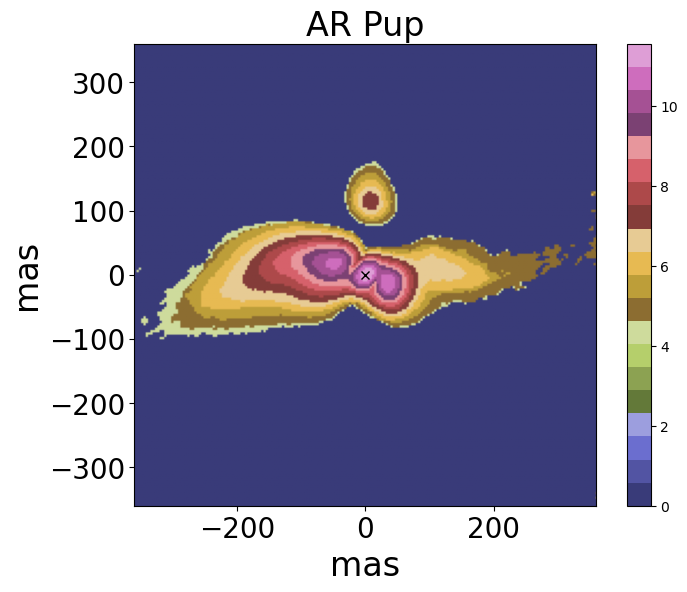

In [5]:

if zimp_to_irdis[star]=='none':
    
    pi_V=Loadimage(figfolder+'PI/',star+'_'+'V'+'_decon.fits')                       # write output
    pi_I=Loadimage(figfolder+'PI/',star+'_'+'I'+'_decon.fits')                       # write output
    #print(figfolder_psf+star+'_'+'V'+'_'+'I'+'meancombined.fits')                       # write output
    #pi_V=Loadimage(figfolder_psf,star+'_'+'V'+'_'+'PI'+'_corr_tel+unres.fits')                       # write output
    #pi_I=Loadimage(figfolder_psf,star+'_'+'I'+'_'+'PI'+'_corr_tel+unres.fits')                       # write output
    

    i_V=Loadimage(figfolder_psf,star+'_'+'V'+'_'+'I'+'_meancombined.fits')                       # write output
    i_I=Loadimage(figfolder_psf,star+'_'+'I'+'_'+'I'+'_meancombined.fits')                       # write output

    
    if star=='V709_Car':
        cosi_V=np.cos(np.deg2rad(19))
        cosi_I=np.cos(np.deg2rad(23))
        
    if star=='HR4226':
        cosi_V=np.cos(np.deg2rad(50))
        cosi_I=np.cos(np.deg2rad(40))
    if star=='01.SCI_AR_Pup':
        cosi_V=1
        cosi_I=1
 

    n=i_V.shape[0]
     #Creating grid         
    xr = np.linspace(0, n, num=n)
    yr = np.linspace(0, n, num=n)
    xr = xr-0.5
    yr = yr-0.5
    Xr, Yr = np.meshgrid(xr, yr)
      
    R=np.sqrt(Xr**2 + (Yr)**2)
    R_deproj_V=np.sqrt(Xr**2 + (Yr/cosi_V)**2)
    R_deproj_I=np.sqrt(Xr**2 + (Yr/cosi_I)**2)
   

    mask=(R<=1500/ps)
    #print(i_I.shape[0])
    #print(R.shape[0])

    i_sum_I=np.sum(i_I[mask])
    i_sum_V=np.sum(i_V[mask])
    
    pi_V[pi_V<1]=0
    pi_I[pi_I<1]=0
     #print(np.max(pi_H_resc_norm))
    pi_V_norm=pi_V/i_sum_V*R_deproj_V*R_deproj_V*10#*(pi_V>=1)
    pi_I_norm=pi_I/i_sum_I*R_deproj_I*R_deproj_I*10#*(pi_I>=1)

    array=np.array([pi_V_norm,pi_I_norm])
    #print(array.shape)

    pi_combine=np.sum(array,axis=0)

    fig, ax = plt.subplots(figsize=(8,6))
    #image=pi_combine

    #image=np.log10(pi_combine+1)
    image=np.arcsinh(pi_combine)
    d = (n-1) * ps / 2
    extent=(-d, d, d, -d)

    cmap='tab20b'
    max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    im=plt.imshow(image, vmin=min, vmax=max,extent=extent,cmap=cmap)
    plt.plot(0,0,'x', color='black')
    plt.xlim(-lim * ps, lim * ps)
    plt.ylim(-lim * ps, lim * ps)
    plt.xlabel('mas', fontsize=24)
    plt.ylabel('mas', fontsize=24)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20) 
    plt.title(starnames[star], fontsize=24) 
    cbar = fig.colorbar(im,ax=ax, orientation='vertical')


    f.scale_mas(star,ax)  

    #plt.title('All PI') 
    plt.savefig(savefig_folder+star+'_all_pi_discret.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()

## Plot with contours

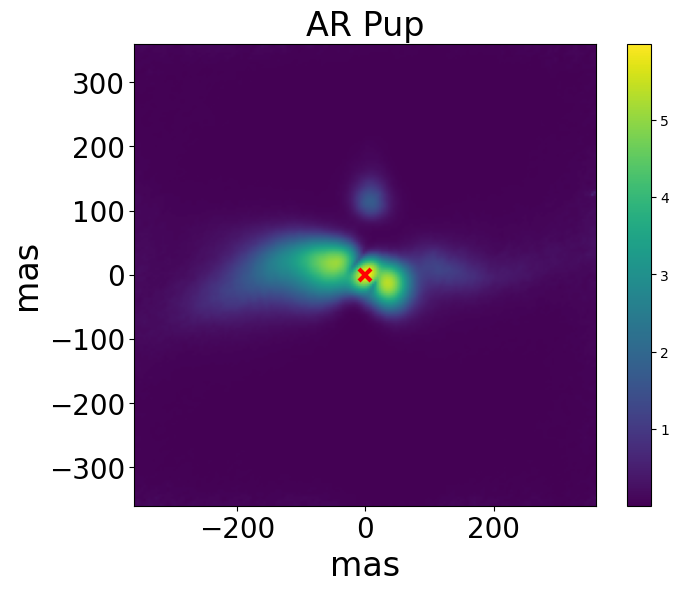

In [6]:

pi_V=Loadimage(figfolder+'PI/',star+'_'+'V'+'_decon.fits')                       # write output
pi_I=Loadimage(figfolder+'PI/',star+'_'+'I'+'_decon.fits')                       # write output
#print(figfolder_psf+star+'_'+'V'+'_'+'I'+'meancombined.fits')                       # write output
#pi_V=Loadimage(figfolder_psf,star+'_'+'V'+'_'+'PI'+'_corr_tel+unres.fits')                       # write output
#pi_I=Loadimage(figfolder_psf,star+'_'+'I'+'_'+'PI'+'_corr_tel+unres.fits')                       # write output
    

i_V=Loadimage(figfolder_psf,star+'_'+'V'+'_'+'I'+'_meancombined.fits')                       # write output
i_I=Loadimage(figfolder_psf,star+'_'+'I'+'_'+'I'+'_meancombined.fits')                       # write output


n=i_V.shape[0]
 #Creating grid         
xr = np.linspace(0, n, num=n)
yr = np.linspace(0, n, num=n)
xr = xr-0.5
yr = yr-0.5
Xr, Yr = np.meshgrid(xr, yr)            
R=np.sqrt(Xr**2+ Yr**2)
mask=(R<=1500/ps)
#print(i_I.shape[0])
#print(R.shape[0])

i_sum_I=np.sum(i_I[mask])
i_sum_V=np.sum(i_V[mask])

#print(np.max(pi_H_resc_norm))
pi_V_norm=pi_V/i_sum_V*20000
pi_I_norm=pi_I/i_sum_I*20000


array=np.array([pi_V_norm,pi_I_norm])

pi_combine=np.sum(array,axis=0)
pi_combine_max=np.max(pi_combine[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])


xr = np.linspace(-n/2, n/2, num=n)
yr = np.linspace(-n/2, n/2, num=n)
x0 = 0.5
y0 = 0.5
xr = xr-x0
yr = yr-y0
X, Y = np.meshgrid(xr, yr)

fig, ax = plt.subplots(1,1,figsize=(8,6))
#image=pi_combine

#image=np.log10(pi_combine)
image=np.arcsinh(pi_combine)
d = (n-1) * ps / 2
extent=(-d, d, d, -d)

cmap='viridis'
max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
im=plt.imshow(image, vmin=min, vmax=max, extent=extent,cmap=cmap)

plt.plot(0,0,'x', color='red', markersize=8, mew=3)
plt.xlim(-lim * ps, lim * ps)
plt.ylim(-lim * ps, lim * ps)
plt.xlabel('mas', fontsize=24)
plt.ylabel('mas', fontsize=24)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20) 
plt.title(starnames[star], fontsize=24) 
cbar = fig.colorbar(im,ax=ax, orientation='vertical')


f.scale_mas(star,ax)  

#plt.title('All PI') 
plt.savefig(savefig_folder+star+'_sum_pi.png',bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()

In [7]:

diam_nir = {'HR4049_combined':16.4,'V709_Car':1.5,'HR4226':0,'01.SCI_UMon':5.49,'01.SCI_AR_Pup':0}
width_nir = {'HR4049_combined':0.8,'V709_Car':0.6,'HR4226':0,'01.SCI_UMon':0.02,'01.SCI_AR_Pup':0}

outdiam_mid = {'HR4049_combined':42,'V709_Car':140,'HR4226':58,'01.SCI_UMon':50, '01.SCI_AR_Pup':63}
subl_radius= {'HR4049_combined':6.6,'V709_Car':3,'HR4226':7.4,'01.SCI_UMon':7, '01.SCI_AR_Pup':1.7}
half_light_radius_mid = {'HR4049_combined':12.5,'V709_Car':75,'HR4226':18,'01.SCI_UMon':18, '01.SCI_AR_Pup':25}


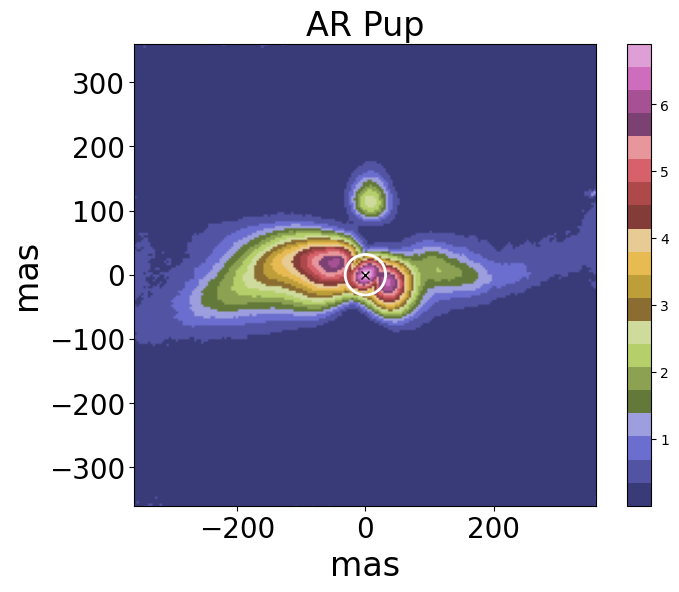

In [10]:
camera = 'ZIMPOL/'
stars = ['01.SCI_AR_Pup']

for star in stars:
    if star=='01.SCI_AR_Pup':
        lim=100
    else:
        lim=50

    dirdat0 = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unres+PSFcorr/'+star+'/'
    if star=='01.SCI_AR_Pup':
        dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Deconvolution_corr_tel/'+camera  #For IRAS08
    else:
        dirdat = '/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Deconvolution_corr_tel+unres/'+camera  #For IRAS08

    figfolder=dirdat +'deconvolved_'
    figfolder_psf='/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/'+star+'/Unres+PSFcorr/'+star+'/'

        #pi_H_resc=[]
    pi_V=Loadimage(figfolder+'PI/',star+'_'+'V'+'_decon.fits')                       # write output
    pi_I=Loadimage(figfolder+'PI/',star+'_'+'I'+'_decon.fits')                       # write output
    #print(figfolder_psf+star+'_'+'V'+'_'+'I'+'meancombined.fits')                       # write output


    i_V=Loadimage(figfolder_psf,star+'_'+'V'+'_'+'I'+'_meancombined.fits')                       # write output
    i_I=Loadimage(figfolder_psf,star+'_'+'I'+'_'+'I'+'_meancombined.fits')                       # write output



    n=i_V.shape[0]
     #Creating grid
    xr = np.linspace(0, n, num=n)
    yr = np.linspace(0, n, num=n)
    xr = xr-0.5
    yr = yr-0.5
    Xr, Yr = np.meshgrid(xr, yr)
    R=np.sqrt(Xr**2 + (Yr)**2)


    mask=(R<=1500/ps)
    #print(i_I.shape[0])
    #print(R.shape[0])

    i_sum_I=np.sum(i_I[mask])
    i_sum_V=np.sum(i_V[mask])

    # if star=='01.SCI_UMon':
    #     pi_H_resc[pi_H_resc<1.2]=0
    # elif star=='HR4049_combined':
    #     pi_H_resc[pi_H_resc<3]=0
    # else:
    #     pi_H_resc[pi_H_resc<0.5]=0

    if star=='V709_Car' or star=='HR4226':
        pi_V[pi_V<1]=0
        pi_I[pi_I<1]=0

    # if zimp_to_irdis[star]!='none': pi_H_resc_norm=pi_H_resc/i_sum_H*50000#*R*R#*()
    #print(np.max(pi_H_resc_norm))
    pi_V_norm=pi_V/i_sum_V*50000#*R*R#*(pi_V>=1)
    pi_I_norm=pi_I/i_sum_I*50000#*R*R#*(pi_I>=1)

    # if zimp_to_irdis[star]!='none':
    #     array=np.array([pi_H_resc_norm, pi_V_norm,pi_I_norm])
    # else:
    array=np.array([pi_V_norm,pi_I_norm])

    pi_combine=np.sum(array,axis=0)
    pi_combine_max=np.max(pi_combine[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])


    xr = np.linspace(-n/2, n/2, num=n)
    yr = np.linspace(-n/2, n/2, num=n)
    x0 = 0.5
    y0 = 0.5
    xr = xr-x0
    yr = yr-y0
    X, Y = np.meshgrid(xr, yr)

    fig, ax = plt.subplots(figsize=(8,6))
    #image=pi_combine

    #image=np.log10(pi_combine)
    image=np.arcsinh(pi_combine)
    d = (n-1) * ps / 2
    extent=(-d, d, d, -d)

    cmap='tab20b'
    max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    im=plt.imshow(image, vmin=min, vmax=max, extent=extent,cmap=cmap)
    out_mid = plt.Circle((0,0), outdiam_mid[star]/2, color='w', fill=False, linewidth=2) #outer
    sublim = plt.Circle((0,0), subl_radius[star], color='w', fill=False, linewidth=2) #outer
    #hlr = plt.Circle((0,0), half_light_radius_mid[star], color='w', fill=False, linewidth=2, ls='--') #outer
    out_nir = plt.Circle((0,0), diam_nir[star]/2+width_nir[star], color='red', fill=False, linewidth=2) #outer
    in_nir = plt.Circle((0,0), diam_nir[star]/2, color='red', fill=False, linewidth=2) #outer

    # Add the circle to the plot
    ax.add_patch(out_mid)
    ax.add_patch(sublim)
    ax.add_patch(out_nir)
    ax.add_patch(in_nir)
  #levels = [pi_combine_max/100, pi_combine_max/2]  # Adjust this as needed
    #CS = ax.contour(X*ps, Y*ps, pi_combine, levels=levels, colors=['white', 'black'], extent=extent)
    #levels = [1.1]  # Adjust this as needed
    #CS = ax.contour(X*ps, Y*ps, pi_I, levels=levels, colors=['white'], extent=extent)
    #levels = [1]  # Adjust this as needed
    #CS = ax.contour(X*ps, Y*ps, pi_V, levels=levels, colors=['violet'], extent=extent)

    plt.plot(0,0,'x', color='black')
    plt.xlim(-lim * ps, lim * ps)
    plt.ylim(-lim * ps, lim * ps)
    plt.xlabel('mas', fontsize=24)
    plt.ylabel('mas', fontsize=24)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    plt.title(starnames[star], fontsize=24)
    cbar = fig.colorbar(im,ax=ax, orientation='vertical')


    f.scale_mas(star,ax)

    #plt.title('All PI')
    plt.savefig(savefig_folder+star+'_all_pi_discret.png',bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()

In [13]:
savefig_folder

'/Users/aksitadeo/PycharmProjects/PythonProject/SPHERE_data/01.SCI_AR_Pup/IRDIS+ZIMPOL/'